In [267]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



# Chargement des données

In [268]:
data_march = pd.read_csv('listings.csv')
data_december = pd.read_csv('listings (1).csv')
data_september = pd.read_csv('listings (2).csv')
data= pd.concat([data_march,data_december,data_september])

In [269]:
# data.isnull().mean().sort_values(ascending=False).sum() * 100

In [270]:
data['host_is_superhost'].isnull().count()

226668

In [271]:
# data.columns


In [272]:
# data.columns.tolist()

In [273]:
# data.values.tolist()
# data.to_numpy()

In [274]:
# data.sort_values(ascending=False, by='beds')

# Supprimer les symboles de devise et convertir en flottant

In [275]:
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)


In [276]:
# data['host_is_superhost'].isna().sum()

In [277]:

# data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)


# Suppression des doublons

In [278]:

print("Nombre de doublons avant suppression :", data.duplicated().sum())
data = data.drop_duplicates()
print("Nombre de doublons après suppression :", data.duplicated().sum())

# c. Gestion des valeurs manquantes
numerical_columns = ['accommodates', 'bedrooms', 'bathrooms']
imputer = SimpleImputer(strategy='median')
imputer.fit(data[numerical_columns])
data[numerical_columns] = imputer.transform(data[numerical_columns])
data = data.fillna(0)

Nombre de doublons avant suppression : 0
Nombre de doublons après suppression : 0


# Supprimer les espaces avant et après les noms de colonnes

In [279]:

data.columns.str.strip()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# Sélection des colonnes pertinentes

In [280]:

# Index des colonnes
column_index = ['accommodates', 'bedrooms', 'bathrooms', 'property_type', 'room_type', 'amenities', 'price']


# Sélection des colonnes pertinentes dans les données
data = data[column_index]



# Gestion des valeurs manquantes

In [281]:

#  Gestion des valeurs manquantes
numerical_columns = ['accommodates', 'bedrooms', 'bathrooms']
imputer = SimpleImputer(strategy='median')
imputer.fit(data[numerical_columns])
data[numerical_columns] = imputer.transform(data[numerical_columns])


# Remplacer les valeurs manquantes dans les colonnes non numériques par 0

In [282]:
data = data.fillna(0)

In [283]:
# data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)
# data['host_location']= data['host_location'].fillna('Unknown')

# Analyse descriptive des données

In [284]:
print(data.describe())

        accommodates       bedrooms      bathrooms          price
count  226668.000000  226668.000000  226668.000000  226668.000000
mean        3.147515       1.214852       1.056144     204.534720
std         1.642789       0.742101       0.310699     591.235555
min         1.000000       0.000000       0.000000       0.000000
25%         2.000000       1.000000       1.000000      70.000000
50%         2.000000       1.000000       1.000000     120.000000
75%         4.000000       1.000000       1.000000     201.000000
max        16.000000      50.000000      48.000000   84420.000000



# Conversion des types de colonnes

# Séparation des données en ensembles d'entraînement et de test

In [285]:
X = data.drop('price', axis=1)
y = data['price']


In [286]:
# Remplacer les valeurs de 'amenities' par le nombre de commodités
data['amenities'] = data['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

In [287]:
# Traitement des données catégorielles (one-hot encoding)
data = pd.get_dummies(data, columns=['property_type', 'room_type'])

In [288]:

# Division des données en ensembles d'entraînement et de test
X = data.drop('price', axis=1)
y = data['price']



# Vérification des colonnes de X_train et X_test
if not X.columns.equals(X.columns):
    raise ValueError("Les colonnes de X_train et X_test ne sont pas identiques")

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.2, random_state=42)

In [289]:
# data.describe()

In [290]:
# data.select_dtypes(exclude=['float64', 'int64']).columns


# Régression linéaire simple 

In [291]:
# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

LinearRegression()

In [292]:
# Faire des prédictions sur les données de test
predictions = model.predict(X_test)

In [293]:

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("MSE (Régression Linéaire):", mse)

# Régression linéaire simple pour la variable 'accommodates'
model_simple = LinearRegression()
model_simple.fit(X_train[['accommodates']], y_train)
predictions_simple = model_simple.predict(X_test[['accommodates']])
mse_simple = mean_squared_error(y_test, predictions_simple)
print("MSE (Régression Linéaire Simple):", mse_simple)


MSE (Régression Linéaire): 3.290345984958176e+20
MSE (Régression Linéaire Simple): 235602.17449197147


MSE (Régression Linéaire Multiple) : 3.290345984958176e+20


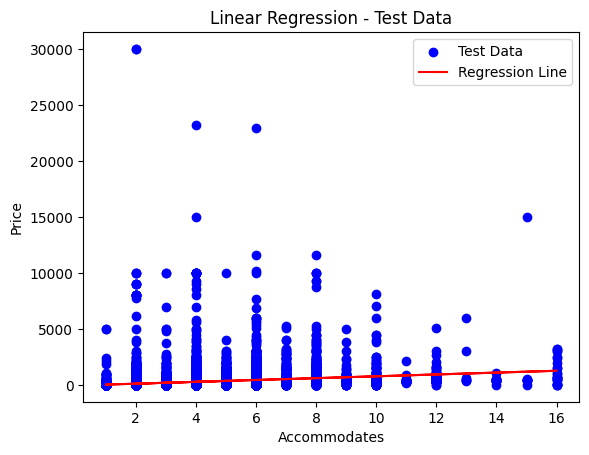

In [294]:

# Régression linéaire multiple
model_multiple = LinearRegression()
model_multiple.fit(X_train, y_train)
predictions_multiple = model_multiple.predict(X_test)
mse_multiple = mean_squared_error(y_test, predictions_multiple)
print("MSE (Régression Linéaire Multiple) :", mse_multiple)

# Visualisation des résultats (optionnel)
plt.scatter(X_test['accommodates'], y_test, color='blue', label='Test Data')
plt.plot(X_test['accommodates'], predictions_simple, color='red', label='Regression Line')
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Linear Regression - Test Data')
plt.legend()
plt.show()

Entraînement et évaluation des modèles 

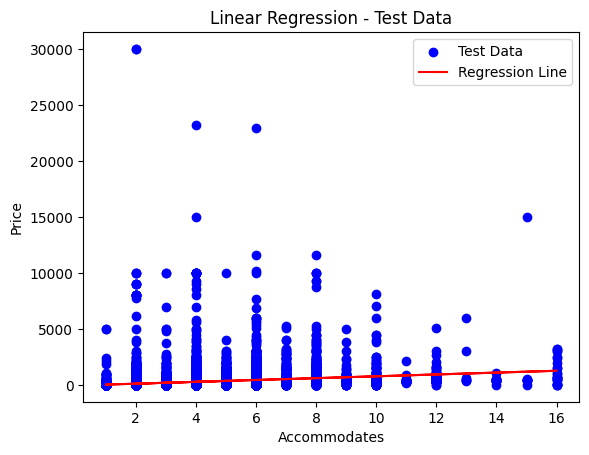

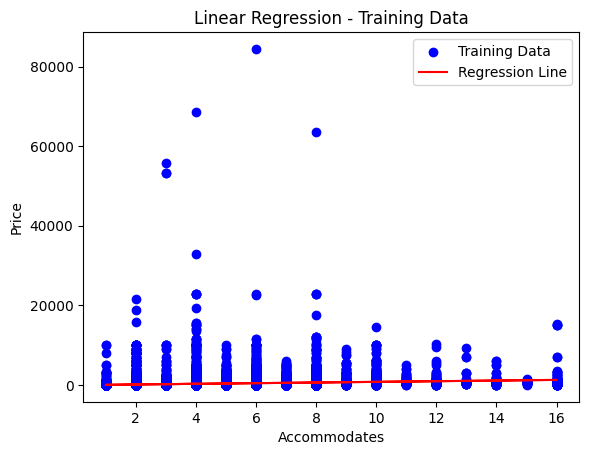

In [295]:
# Visualisation des résultats
plt.scatter(X_test['accommodates'], y_test, color='blue', label='Test Data')
plt.plot(X_test['accommodates'], predictions_simple, color='red', label='Regression Line')
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Linear Regression - Test Data')
plt.legend()
plt.show()

# Visualisation des données d'entraînement
plt.scatter(X_train['accommodates'], y_train, color='blue', label='Training Data')
plt.plot(X_train['accommodates'], model_simple.predict(X_train[['accommodates']]), color='red', label='Regression Line')
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Linear Regression - Training Data')
plt.legend()
plt.show()

# Entraînement et évaluation des modèles pour chaque période

In [296]:

# Combinaison des données des trois périodes
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.2, random_state=42)

# Régression linéaire simple pour l'ensemble combiné
model_all_simple = LinearRegression()
model_all_simple.fit(X_train_all[['accommodates']], y_train_all)
predictions_all_simple = model_all_simple.predict(X_test_all[['accommodates']])
mse_all_simple = mean_squared_error(y_test_all, predictions_all_simple)
print("MSE pour les trois périodes combinées (Régression Linéaire Simple):", mse_all_simple)



MSE pour les trois périodes combinées (Régression Linéaire Simple): 235602.17449197147


# Concaténer les données de toutes les périodes

In [297]:
# Entraîner un modèle de régression linéaire sur les données combinées
# model = LinearRegression()
# model.fit(data[['accommodates']], data)

# # Tracer la régression linéaire sur les données d'entraînement combinées
# plt.scatter(data['accommodates'], data['price'], color='blue', label='Training Data')
# plt.plot(data['accommodates'], model.predict(data[['accommodates']]), color='red', label='Regression Line')
# plt.xlabel('Accommodates')
# plt.ylabel('Price')
# plt.title('Linear Regression - Combined Training Data')
# plt.legend()
# plt.show()

# Calcul des pourcentages d'erreurs quadratiques moyennes pour chaque modèle

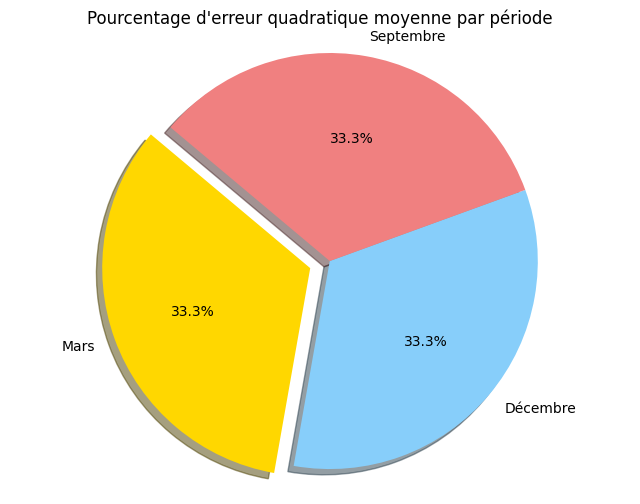

In [298]:
percentage = mse_simple * 100

labels = ['Mars', 'Décembre', 'Septembre']
sizes = [percentage] * len(labels)  # Répéter la valeur de percentage pour chaque période
colors = ['gold', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  # Explosion du premier segment

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pourcentage d\'erreur quadratique moyenne par période')
plt.axis('equal')  # Assure un cercle parfait
plt.show()






# Faire des prédictions sur les données de test

In [299]:
# predictions= model.predict(X_test)

# # Calculer l'erreur quadratique moyenne pour mars
# mse = mean_squared_error(y_test, predictions)




# Prédictions combinées pour chaque mois

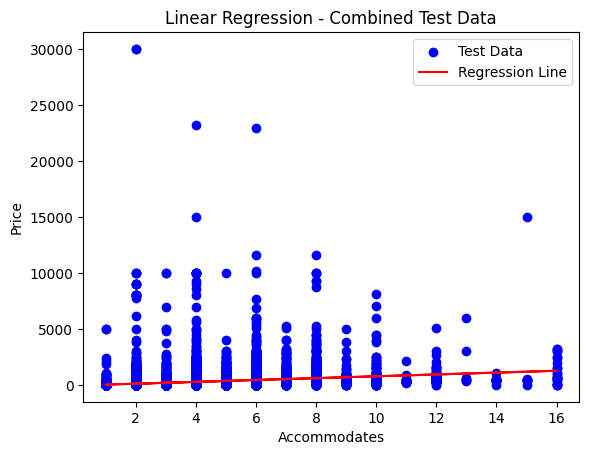

In [300]:
plt.scatter(X_test_all['accommodates'], y_test_all, color='blue', label='Test Data')
plt.plot(X_test_all['accommodates'], predictions_all_simple, color='red', label='Regression Line')
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Linear Regression - Combined Test Data')
plt.legend()
plt.show()

# Plot des vraies valeurs par rapport aux prédictions

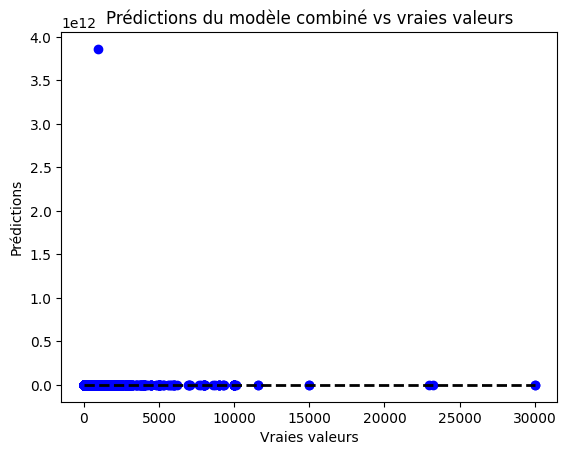

In [301]:

plt.scatter(y_test, predictions, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Droite y = x
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Prédictions du modèle combiné vs vraies valeurs')
plt.show()

# Utilisation des modèles pour prédire les prix pour un nouveau logement

In [303]:
# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédiction pour un nouveau logement 
new_listing = pd.DataFrame({'accommodates': [5], 'bedrooms': [2], 'bathrooms': [1.5]})
predicted_price = model.predict(new_listing)
print("Prix estimé pour un nouveau logement  :", predicted_price)




ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- amenities
- property_type_Barn
- property_type_Boat
- property_type_Camper/RV
- property_type_Casa particular
- ...


In [ ]:

# Calcul de la moyenne des prix prédits pour les trois périodes
predicted_price / 3

predicted_price


NameError: name 'predicted_price' is not defined

In [ ]:


# Création du DataFrame pour les prédictions
predictions = pd.DataFrame({
    'Période': ['Mars', 'Décembre', 'Septembre'],
    'Prix estimé': [predicted_price[0]]
})

# Tracé du graphique
plt.figure(figsize=(8, 6))
plt.bar(predictions['Période'], predictions['Prix estimé'], color=['blue', 'green', 'orange'])
plt.title('Estimation du prix pour un nouveau logement sur différentes périodes')
plt.xlabel('Période')
plt.ylabel('Prix estimé')
plt.show()


NameError: name 'predicted_price' is not defined